In [ ]:
# run for local jupyter notebook
%matplotlib notebook
from fits_mask_tools import FitsViewer, BackgroundInteractive, MaskPainter, BinnedFitsViewer, ImageCropper
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [2]:
from galaxylib import GalaxyLibrary

FLUXMAG0 = 63095734448.0194 # counts to magnitudes
IMAGE_PSF = 1.0 / 0.2 / 2.355 # 1 arcsec FWHM PSF
IMAGE_SCALE = 0.2 # pixel size in arcsec
library_path = './library'

lib = GalaxyLibrary(library_path)
library_files = lib.load_and_plot()

n_x = 5000
n_y = 5000

# create a mosaic of galaxies
canvas = lib.create_canvas((5000, 5000), n_objects=300, seed=1, z_min=0.08)
canvas = lib.create_canvas((5000, 5000), n_objects=50, seed=8, z_min=0., z_max=0.08)

canvas = lib.inject_specific(canvas, [
                                    ('obj_00019_z0.05_658.h5', 500, 1500),
                                    ('obj_00135_z0.05_904.h5', 1500, 1500),
                                    ('obj_00038_z0.05_658.h5', 2500, 4000),
                                    ('obj_00073_z0.05_791.h5', 2000, 3000),
                                    ('obj_00009_z0.05_904.h5', 2500, 2500),
                                    ('obj_00076_z0.05_658.h5', 3000, 4000),
                                    ('obj_00028_z0.05_791.h5', 1000, 4500),
                                    ('obj_00025_z0.05_658.h5', 2000, 2000),
                                    ('obj_00138_z0.05_904.h5', 500, 2500),
                                    ('obj_00003_z0.05_791.h5', 3500, 3000),
                                    ('obj_00001_z0.05_658.h5', 3000, 3500),
                                    ('obj_00003_z0.05_904.h5', 2000, 3250),
                                ])

canvas = lib.inject_specific(canvas, [('obj_00001_z0.05_904.h5', n_x//2-1200, n_y//2-1200)])
canvas = lib.inject_specific(canvas, [('obj_00019_z0.05_904.h5', n_x//2, n_y//2)])

canvas_adu = canvas * FLUXMAG0

del canvas

# add a sky and stars
img_sky, bg_model, noise = lib.add_sky(canvas_adu,
            sky_mag=22.0,
            fluxmag0=FLUXMAG0,
            pixscale=IMAGE_SCALE,
            effective_gain=300.,
            n_stars=100,
            star_mag_range=(18., 22.),
            psf_sigma=IMAGE_PSF,
            sb_noise_mag=31.0,
            seed=1)

## Images

We start with a clean mosaic of galaxy cutouts placed on a large blank canvas.

<IPython.core.display.Javascript object>


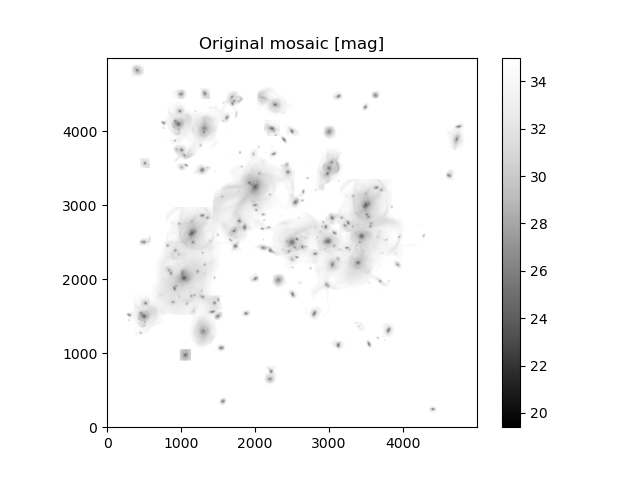

/tmp/ipykernel_43836/940221826.py:2: RuntimeWarning: divide by zero encountered in log10
  h = plt.imshow(-2.5*np.log10(canvas_adu)+27, origin='lower', cmap='Greys_r', vmax=35);


In [3]:
plt.figure()
h = plt.imshow(-2.5*np.log10(canvas_adu)+27, origin='lower', cmap='Greys_r', vmax=35);
plt.colorbar(h);
plt.title('Original mosaic [mag]');

## Sources of Background

In astronomical imaging, the measured signal contains not only light from astrophysical sources, but also a variety of unwanted contributions collectively referred to as the background. Understanding these components is important because each behaves differently across the detector and may require different strategies for removal.

Some common sources of background include:

- **Sky glow.** Emission from the Earth's atmosphere, including airglow lines and scattered moonlight or twilight, produces a smooth but sometimes spatially varying background that changes over time.  
- **Zodiacal light.** Sunlight scattered by interplanetary dust introduces a low-level, often nearly uniform illumination across the field.  
- **Galactic cirrus.** Diffuse, filamentary dust clouds in the Milky Way that scatter starlight and emit at infrared wavelengths. Cirrus structures are faint and spatially variable, often creating low-surface-brightness features that can be mistaken for extragalactic emission. Because their morphology is complex and covers a wide range of spatial scales, cirrus is difficult to model or remove using standard background estimation. Auxiliary infrared observations are often used to identify and characterise cirrus, helping to distinguish it from genuine astrophysical sources in the optical or near-infrared.
- **Scattered light and reflections.** Internal reflections within the telescope or camera optics, such as ghosts or halos around bright stars, produce structured background patterns that may be localized or extend across the field.  
- **Instrumental artefacts and CCD-to-CCD variations.** In mosaic cameras or multi-amplifier detectors, each CCD or amplifier can have slightly different sensitivity, bias level, or flat-field response. This produces small step-like differences or gradients across the field. If uncorrected, these differences appear as residual background structure and can interfere with the detection of faint sources.

Each of these sources has characteristic spatial and temporal behaviour. Some vary slowly across the frame (e.g., zodiacal light), while others are more localized (e.g., scattered-light ghosts) and some are diffuse but structured on intermediate scales (e.g., Galactic cirrus).

We model the sky as a smooth polynomial sky. Notice that the background is comparable or greater in brightness to many of the objects. There is also a small gradient across the image. Even a small variation in background level, for example a difference of a few hundredths or tenths of a magnitude across a detector, corresponds to a few per cent change in flux. That background variation alone approaches the contrast level of many low-surface-brightness features with intrinsic contrasts meaning they are easily masked.

<IPython.core.display.Javascript object>


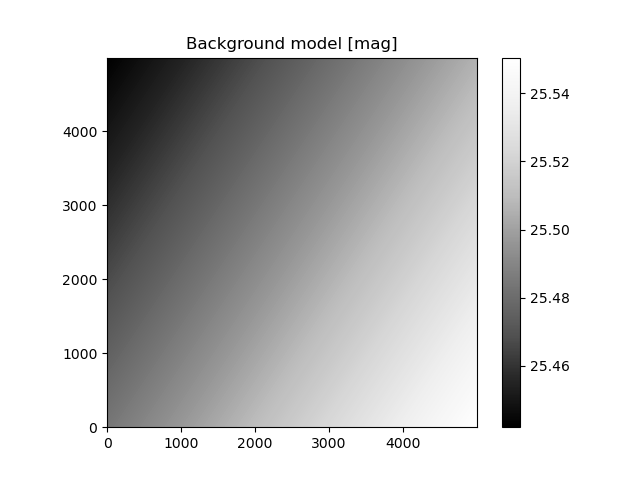

In [4]:
plt.figure()
h = plt.imshow(-2.5*np.log10(bg_model)+27, origin='lower', cmap='Greys_r');
plt.colorbar(h);
plt.title('Background model [mag]');

We then add the polynomial sky to the original clean mosaic, along with a population of point sources to represent stars, and finally Poisson noise plus a small Gaussian term to mimic scattered light. After these steps, many faint objects, particularly the low-surface-brightness outskirts of galaxies, become undetectable.  

The key factor is **contrast**, not the absolute per-pixel magnitude. Let the local background flux per pixel be $F_{\rm sky}$ (linear units), and the flux of the object of interest be $F_{\rm obj}$. A feature is detectable only when the **flux contrast** exceeds the local noise:

$$
\Delta F \equiv F_{\rm obj} \gtrsim k\, \frac{\sigma_F}{\sqrt{N_{\rm eff}}},
$$

where:

- $k$ is the desired significance (typically 3),
- $\sigma_F$ is the 1$\sigma$ noise in flux per pixel,
- $N_{\rm eff}$ is the effective number of independent pixels in the detection; for an aperture $N_{\rm pix}=A_{\rm aperture}/\text{pixarea}$).

In terms of magnitudes, the $k\sigma$ surface-brightness limit can be expressed as:

$$
\mu_{3\sigma} = -2.5 \log_{10} \Big(k\, \sigma_F \sqrt{N_{\rm eff}} \Big),
$$

where $F_{\rm sky,ap}$ is the total background flux over the aperture or PSF footprint. The contrast $\Delta\mu = \mu_{3\sigma} - \mu_{\rm obj}$ then indicates whether the object is detectable.  

Two effects combine to limit detectability:

1. **Background gradient** shifts $F_{\rm sky}$ across the image, reducing local contrast in some regions.  
2. **Noise** sets the statistical threshold for detection.  

<IPython.core.display.Javascript object>


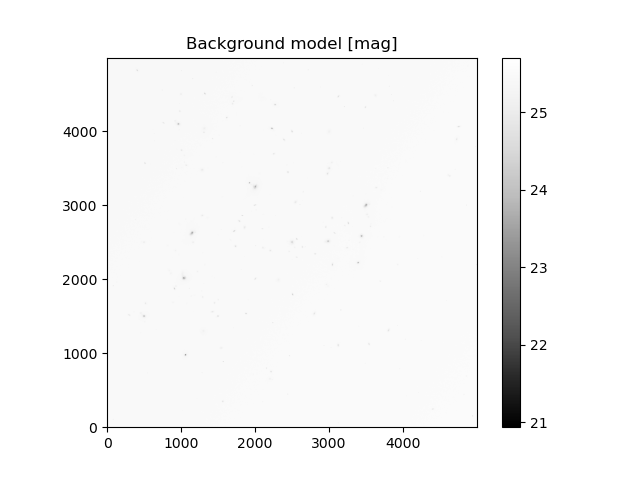

In [5]:
plt.figure()
h = plt.imshow(-2.5*np.log10(img_sky)+27, origin='lower', cmap='Greys_r');
plt.colorbar(h);
plt.title('Background model [mag]');

*note: in our example the sky is idealised, the PSF does not vary and real instrumental artefacts are not included. The images are therefore good for controlled experiments, but they are a bit more forgiving than real survey data.*

## Exercise — detectability from the background map

**Given:** `bg_map` (counts), `IMAGE_SCALE` (arcsec/pix)

In [9]:
bg_map = noise + bg_model

**Tasks**

1. Compute the median background

2. Estimate the per-pixel 1σ scatter

In [10]:
# hint
#print(f'background median counts = {np.median(bg_map)}, background standard deviation = {np.std(bg_map)}')

3. Compute the 3$\sigma$ surface-brightness limit for a $10\times10''$ square aperture. Let $F_{\rm sky,ap}$ be the total background flux in the aperture and $\sigma_F$ the per-pixel flux noise:

$$
F_{3\sigma,\rm ap} = 3 \, \sigma_F \sqrt{N_{\rm pix}}, 
\quad N_{\rm pix} = \frac{10^2}{\text{pixscale}^2}.
$$

Convert back to magnitudes to get the surface-brightness limit:

$$
\mu_{3\sigma,\rm ap} = -2.5 \log_{10} F_{3\sigma,\rm ap} + Zp.
$$

where, for our data, the zero-point, $Zp$ = 27

Repeat for just the noise alone, without the background

In [11]:
bg_map = noise

what is the main source that is limiting detectability?

## Background estimation

### Modelling the Background

Background estimation is sensitive to both the spatial scale of genuine sky variations and the characteristic sizes of astrophysical sources. A practical approach is to divide the image into tiles and estimate a representative value within each. The choice of tile size matters, because it sets the scale over which the background is allowed to vary.

A background that is measured over very small regions tends to track local fluctuations too closely. Noise peaks, faint wings of galaxies, or scattered light can all be misinterpreted as real structure in the background. The resulting model becomes noisy and can imprint artificial patterns on any subsequent measurements.

At the other extreme, very large regions enforce a background that varies too slowly. Genuine gradients, for example from moonlight, twilight residuals, internal reflections, or flat-field imperfections, are averaged out. The fitted surface then underestimates the large-scale structure and leaves systematic residuals across the frame.

Underestimating the background leads to overly bright flux measurements, while overestimating it suppresses faint sources. Spatially varying errors can also bias shape measurements or affect detection thresholds differently across the field.

The choince of tile size therefore needs to avoid both extremes. It should be large enough to smooth over pixel noise and small-scale source structure, but small enough to capture slow gradients across the detector. Once a suitable range has been explored, the resulting model can be inspected by subtracting it from the contaminated image and checking the residuals.

### Other Factors


We will not vary these parameters in the exercise, several additional parameters influence how well the background estimate represents the true sky. They are secondary to the choice of spatial scale but still worth understanding.

- **Filter size.**  
  Once the background has been measured in separate tiles, a smoothing step links those tiles into a continuous surface. If the filter is too small, the background retains the imprint of the grid and develops visible discontinuities. If the filter is too large, the smoothing begins to suppress genuine low-frequency structure. In practice, the filter needs only to be large enough to remove the block pattern without forcing the background to become artificially flat.

- **Sigma clipping.**  
  The estimation procedure attempts to restrict itself to sky pixels by removing outliers. Sigma clipping performs this rejection automatically, but the threshold determines how aggressively the data are trimmed. Weak clipping allows bright pixels to leak into the estimate and raises the inferred background. Strong clipping discards too much of the distribution and can erase real variations in very faint regions. A moderate setting is usually adequate and avoids both extremes.

Although these parameters are not adjusted here, they often explain residual structure in background models. Checkerboard patterns usually point to insufficient filtering, while elevated regions around bright sources indicate insufficient clipping. Understanding these behaviours makes it easier to diagnose problems when analysing real observations.

### Limitations

Background modelling is inevitably a compromise between capturing genuine large-scale structure and avoiding contamination from astrophysical sources. Several constraints follow from this.

- **No single parameter set works for all images.**  
  The optimal tile size depends on the characteristic scales present in the field. Images dominated by compact objects can tolerate smaller tiles, whereas data containing extended galaxies or diffuse emission require larger ones to avoid suppressing real structure. A configuration that performs well for one field may fail for another.

- **Bright or extended sources complicate the estimate.**  
  Very bright stars, large galaxies, or scattered-light halos inflate the local pixel distribution and bias the background upwards. In these cases, it might be necessary to mask these regions or model them explicitly by fitting and subtracting a model PSF or subtracting a smooth galaxy profile before attempting any background estimation.

- **Low-surface-brightness features are vulnerable to over-subtraction.**  
  Diffuse structures that vary slowly across the image sit close to the noise level and can easily be modelled as background. If the chosen scale is too small, these features are partially removed; if too large, they remain but any structure that changes more rapidly than the background model (such as faint galaxy outskirts, tidal features, or diffuse intra-cluster light) can be washed out by variations in the true sky background that are not captured by the model background.

Background estimation requires awareness of the characteristic scales in the data and an understanding of which structures should be preserved and which should be removed.

## Exercise: finding the optimum box size

### What the panels tell you

- **Background map (left).** Should be smooth on the scale set by the box size. If the map shows sharp edges, patchiness, or shapes that mimic bright sources, the algorithm is being influenced by objects rather than by the sky.
- **Residual image (right).** Should ideally contain only sources and noise. Any broad gradients or dark haloes around objects indicate the background model is not well matched to the image.

### Why box size matters

The box (tile) size defines the spatial scale on which the background is assumed to vary.

- **Box size too small.**  
  Small boxes give medians that are easily biased by even a few bright pixels. The estimator starts to see parts of astronomical objects as background because the box does not contain enough uncontaminated pixels. This leads to over-subtraction: galaxies may look hollowed out, and faint extended emission is suppressed. 

- **Box size too large.**  
  Large boxes act like a strong low-pass filter, so only very broad features appear in the background model. The estimator averages over too much of the image and fails to follow real sky gradients or scattered-light features. These structures remain visible in the residual as large, smooth patterns.

### Exercise

Background estimation is sensitive to the presence of bright or extended sources, and to the choice of spatial scale and other parameters. Visual inspection of the residuals is the most reliable way to assess whether the model is appropriate.

1. **Explore the effect of box size.** Run the cell below. Start with a range of box sizes and compute the background for each. Examine how small boxes may overfit local fluctuations around sources, while large boxes may fail to capture gradients in the sky. Note how the residuals change around extended sources.

2. **Assess smoothing and clipping.** Consider how the filter size and sigma clipping affect the smoothness and accuracy of the background. (In this exercise, you will not adjust these parameters, but observe their influence on the residual.)

3. **Identify problematic regions.** Click on the residual to zoom into bright stars, extended galaxies, and blank sky. Look for over- or under-subtraction. 

4. **Examine the relevant scales.** Consider the characteristic sizes of sources or diffuse structures you wish to retain in the image. Select initial box sizes that are large enough not to suppress these features, and small enough to capture global sky variations. Generate background models using a range of box sizes. Focus on whether the scales of interest are preserved.

5. **Inspect the residuals.** Once you have a background that you are happy preserves the desired scales, examine the residual histogram by running ```bg_viewer.plot_residual_hist()``` in the cell below to verify that empty sky is noise-dominated. Skewed distributions, long tails, or large-scale gradients indicate over- or under-subtraction. This function overlays a Gaussian derived from the expected noise with the distribution of values from the residual image. A noise-dominated residual should have a roughly Gaussian distribution centred on zero. Skewness or long tails indicate leftover sources, gradients, or artefacts. The width of the distribution gives the noise level. 

6. **Iterate as needed.** Adjust box size and recompute until the residuals in empty sky are noise-dominated, and genuine astronomical sources retain their expected morphology.

The goal is first to develop an intuitive understanding of how the background estimation behaves under different choices, and then to converge on a scale that removes only the unwanted sky while preserving real structures.

<IPython.core.display.Javascript object>


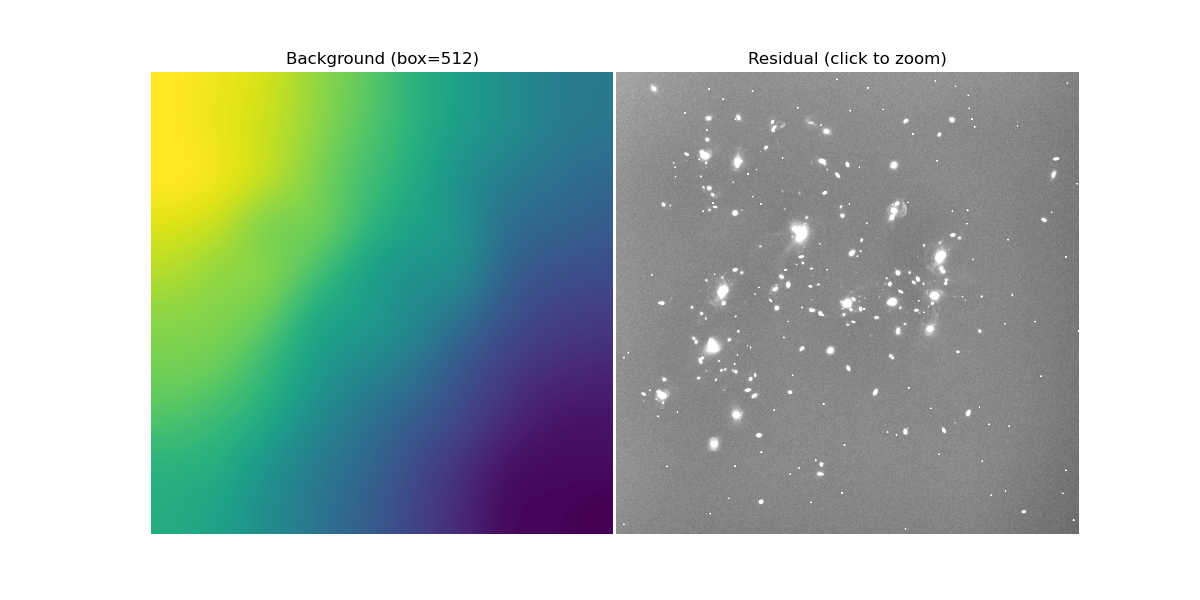

interactive(children=(IntSlider(value=128, continuous_update=False, description='box size', max=1024, min=32, …

In [12]:
bg_viewer = BackgroundInteractive(img_sky, zoom_size=500)
bg_viewer.interact()

<IPython.core.display.Javascript object>


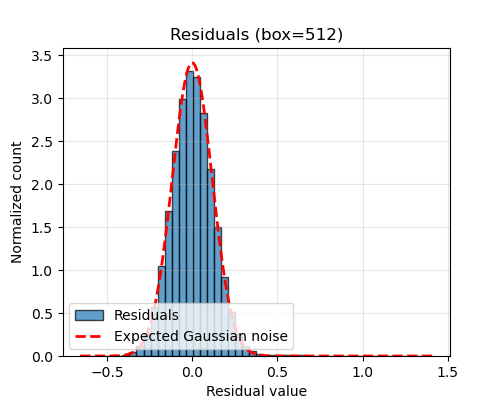

In [14]:
bg_viewer.plot_residual_hist() # rerun this cell to update the histogram for the current box size above

## Image scaling

### Image display parameters

Scaling and stretch determine how pixel values are mapped to display brightness. For low-surface-brightness work this is critical: the wrong choice either buries faint structure in the black point or exaggerates noise and residual sky structure. The interactive controls below let you trade dynamic range for local contrast and choose a nonlinear mapping that reveals faint wings without saturating bright cores.

There are a number of ways that we can rescale an image to emphasise the features we are interested in:

- **Stretch (linear / log / sqrt / asinh).** Nonlinear stretches (asinh, sqrt) compress bright cores while raising faint signal above the background floor. Asinh is usually the safest first choice for faint extended features; log often over-amplifies noise.

- **Contrast.** Controls the effective slope of the transfer function. Lower contrast spreads values and helps see faint gradients; higher contrast emphasises edges and compact structure.

- **White fraction**. Sets where the display’s white point lies between vmin and vmax. Moving it down makes the brightest pixels less dominant and can bring out faint structures.

- **Scaling (%).** Lowering the percentile range (e.g. 95–99) includes more high and low pixels and can expose faint diffuse light, but also risks showing outliers and detector artefacts.

Faint extended emission exists very close to the noise floor. Nonlinear stretches that compress high values (asinh, sqrt) increase the visibility of low counts without clipping bright regions. But any increase in visibility is coupled with amplification of noise and low-level residuals from imperfect background subtraction.

### Exercise: choosing display parameters to reveal low-surface-brightness features

Work after you have picked a background box size with ```bg_viewer``` in the previous exercise. The new plot inherits your chosen box size.

1. **Select a stretch.**  
   Find a stretch that best reveals faint features. Asinh or sqrt usually works well. Note if faint structures appear continuous or grainy (noise).

2. **Adjust contrast.**  
   Reduce contrast in steps. Inspect faint haloes or tidal features at each step: coherent structures indicate successful enhancement; speckled or patchy patterns indicate amplified noise.

3. **Lower the white point.**  
   Changing the white fraction de-emphasises bright cores and makes faint outskirts more visible. Adjust incrementally and observe changes.

4. **Inspect with the zoom tool.**  
   Use the rectangle tool to zoom into regions of interest and the home icon to reset. The inset zoom can help evaluate the morphology: real emission is spatially coherent, while noise is patchy and uncorrelated.

5. **Iterate for optimal settings.**  
   Combine stretch, contrast, and white fraction to highlight faint structures without exaggerating noise or residual gradients.  

6. **Record final values.**  
   Once satisfied, note the final display parameters (stretch, contrast, white fraction, scaling) along with the box size used for the background model.
   
Careful adjustment of image scaling and stretch is important for visualising faint, extended features without misleading amplification of noise or residual background. By iteratively exploring stretch type, contrast, white point, and scaling, you can reveal low-surface-brightness structures in a controlled and consistent way. Record the settings that best preserve coherent faint emission.

<IPython.core.display.Javascript object>


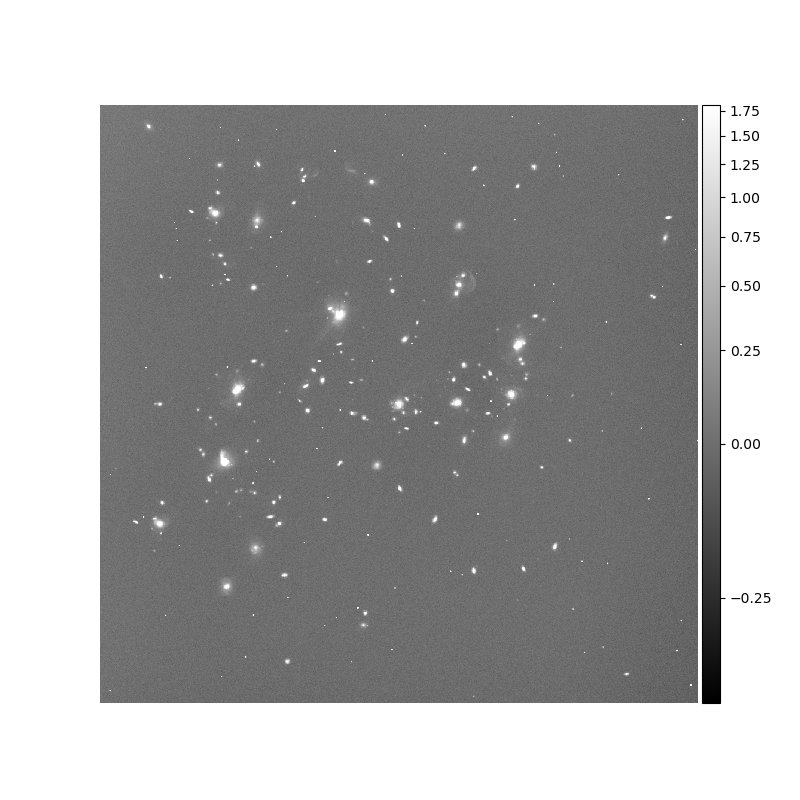

interactive(children=(Dropdown(description='stretch', options=('linear', 'log', 'sqrt', 'asinh'), value='linea…

In [16]:
fv = FitsViewer(bg_viewer.resid)

## Exercise: enhancing faint features through binning

Even after careful background subtraction and image scaling, very low-surface-brightness features may remain difficult to discern. One way to improve detectability is to rebin (co-add) pixels, effectively increasing the signal-to-noise ratio (SNR) at the cost of spatial resolution.  

- **Signal-to-noise ratio (SNR).** When N pixels are combined (for example, in an n×n block), the signal grows linearly with the number of pixels while the noise grows as the square root. For purely Poisson-limited data:  

$$
\mathrm{SNR}_{\rm binned} = \sqrt{N} \, \mathrm{SNR}_{\rm original}
$$

This means faint extended structures may become visible after binning, but small-scale features can blur or disappear.

- Binning reduces high-frequency detail. Stars or compact galaxies may merge with surrounding pixels. Choosing the bin size requires balancing improved SNR with acceptable spatial loss.  

---

### Exercise

1. **Select some regions of interest.** In the image above, you can again use the zoom tool again to isolate several patches of sky containing faint extended emission.  

2. **Apply binning.** Use the slider below to rebin the image with several block sizes (e.g., 2×2, 4×4, 8×8 pixels). The image above will be rebinned. Compare the binned images to the original:  

   - Note which structures become clearer.  
   - Identify whether any features are lost or merged.  

In [17]:
rebinned_fv = BinnedFitsViewer(fv)

IntSlider(value=1, description='Binning', max=20, min=1)

3. **Compare SNR.**  
   - Run the panel below ```cropper = ImageCropper(bg_viewer.resid, bin_size=rebinned_fv.bin_slider.value)``` and again use the square icon to zoom in on a region of interest.


<IPython.core.display.Javascript object>


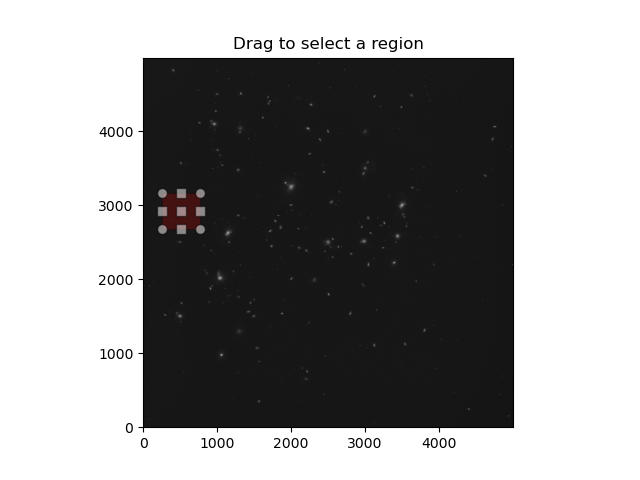

In [18]:
# Drag a rectangle in the displayed figure to select a region
cropper = ImageCropper(bg_viewer.resid, bin_size=rebinned_fv.bin_slider.value)

   - Deselect the zoom tool and then drag across the image to select a rectangular region.
   - First select an empty sky region and retrieve the original and binned versions of the image by running ```original, binned = cropper.get_crops()```.

In [19]:
original, binned = cropper.get_crops()

   - Calculate the standard deviation (```np.std(...```) of both the original and binned region of empty sky.
   - Now do the same for a region of diffuse emission and calculate the mean flux (```np.mean(...```)
   - Confirm that the noise decreases approximately as $1/\sqrt{N}$, where N is the number of pixels per bin.  

4. **Assess optimal binning.**  
   - Choose a bin size that maximises the signal to noise  of the faint extended emission while preserving sufficient spatial information for your science goals. (by moving the slider above and rerunning  ```cropper = ImageCropper(bg_viewer.resid, bin_size=rebinned_fv.bin_slider.value)```)   

6. **Document results.**  
   - Record final bin size, display stretch, contrast, white fraction, and scaling.  
   - Make a note of which features were enhanced and which were compromised.  
   - **Once you are happy with everything run ```rebinned_fv.save_state()``` to save the current state of the binning and image display parameters**. We will use this in the next session.

In [20]:
rebinned_fv.save_state() # make sure you save the state of the for the next session

State saved to bfv_state.pkl


### Aternative approaches to enhance faint features.
While simple binning increases the SNR, it also reduces spatial resolution, potentially merging or blurring small-scale features. Two commonly used strategies can help reveal faint structures without losing as much detail:

- **Adaptive smoothing.** Instead of applying a uniform smoothing scale, the kernel size is adjusted based on the local SNR. Regions with high SNR remain largely unchanged, preserving sharp features, while low-SNR areas are smoothed more strongly. This improves the visibility of faint extended structures while maintaining as much spatial detail as possible.

- **Model subtraction.** Bright galaxies or stars can dominate the flux in a region, masking faint emission nearby. By fitting a model to these sources (e.g., using Sérsic profiles for galaxies or PSF models for stars) and subtracting it, the residual image can reveal low-surface-brightness features that are otherwise hidden under the wings of bright objects.

Each of these methods addresses the trade-off between improving detectability and preserving spatial detail in different ways. In practice, combining techniques can maximise the visibility of very faint, extended features while minimising artefacts and loss of resolution.
